##### Copyright 2020 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load and preprocess images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds
import pickle
def save_obj(obj: object, name: str):
  """
  Save a data-type of interest as a .pkl file

  Args:
      obj (any): variable name of interest
      name (str): string-name for .pkl file
  """
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name: str):
  """
  Load .pkl file from current working directory

  Args:
      name (str): name for .pkl file of interest

  Returns:
      [any]: unpacked .pkl file either in the form of a pd.DataFrame or list
  """
  with open(name + '.pkl', 'rb') as f:
    return pickle.load(f)


In [2]:
print(tf.__version__)

2.6.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [3]:
import pathlib
# dataset_loc= "/home/tristan/Desktop/CodingProjects/trg880/capstone/data.zip"
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('data', origin=dataset_loc, untar=True)
data_dir = pathlib.Path("/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training")
test_dir=pathlib.Path("/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Test")

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

67692


Each directory contains images of that type of flower. Here are some roses:

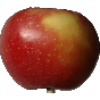

In [5]:
apples = list(data_dir.glob('Apple Braeburn/*'))
PIL.Image.open(str(apples[0]))

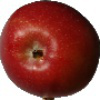

In [6]:
PIL.Image.open(str(apples[1]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

You can find the class names in the `class_names` attribute on these datasets.

### Visualize the data

Here are the first nine images from the training dataset.

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](../../guide/keras/sequential_model.ipynb) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

Note: You will only train for a few epochs so this tutorial runs quickly.

Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](../../guide/keras/writing_a_training_loop_from_scratch.ipynb) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

test_count=len(list(test_dir.glob('*/*.jpg')))
print(test_count)

67692
22688


The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

list_ds_test = tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=False)
list_ds_test = list_ds_test.shuffle(test_count, reshuffle_each_iteration=False)

2021-10-07 20:00:43.629392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
for f in list_ds.take(131):
  print(f.numpy())

for f in list_ds_test.take(131):
  print(f.numpy())

b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Carambula/297_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Melon Piel de Sapo/50_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Pomelo Sweetie/r_140_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Corn/r2_179_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Pear Red/r_283_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Cactus fruit/r_65_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Avocado/0_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Pepper Orange/r_22_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Guava/180_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Training/Hazelnut/212_100.jpg'
b'/home/tristan/Desktop/CodingProjects/trg880/capstone/data/Traini

The tree structure of the files can be used to compile a `class_names` list.

In [10]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

test_class_names = np.array(sorted([item.name for item in test_dir.glob('*') if item.name != "LICENSE.txt"]))
print(test_class_names)

['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Corn' 'Corn Husk'
 'Cucumber Ripe' 'Cucumber Ripe 2' 'Dates' 'Eggplant' 'Fig' 'Ginger Root'
 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White' 'Grape White 2'
 'Grape White 3' 'Grape White 4' 'Grapefruit Pink' 'Grapefruit White'
 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi' 'Kohlrabi' 'Kumquats'
 'Lemon' 'Lemon Meyer' 'Limes' 'Lychee' 'Mandarine' 'Mango' 'Mango Red'
 'Mangostan' 'Maracuja' 'Melon Piel de Sapo' 'Mulberry' 'Nectarine'
 'Nectarine Flat

Split the dataset into training and validation sets:

In [11]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

test_ds=list_ds_test.take(test_count)

train_ds

<SkipDataset shapes: (), types: tf.string>

You can print the length of each dataset as follows:

In [12]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

print(tf.data.experimental.cardinality(test_ds).numpy())


54154
13538
22688


In [13]:
batch_size = 32
img_height = 100
img_width = 100

Write a short function that converts a file path to an `(img, label)` pair:

In [14]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [15]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [16]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
print(train_ds)
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(map_func=process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds1=test_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds =test_ds.map(process_path, num_parallel_calls=AUTOTUNE)


<SkipDataset shapes: (), types: tf.string>


In [18]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (100, 100, 3)
Label:  41


2021-10-07 20:01:19.033797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [19]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds=configure_for_performance(test_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

2021-10-07 20:01:26.161151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


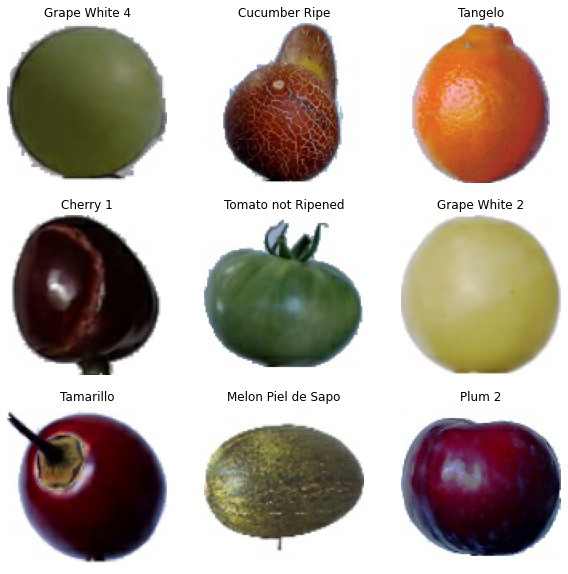

In [20]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [21]:
num_classes = 131

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
epochs=10
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.8457   

KeyboardInterrupt: 

In [28]:
model.save('cnn_ep10_selftrain')

INFO:tensorflow:Assets written to: cnn_ep10/assets


InternalError: Tensorflow type 21 not convertible to numpy dtype.

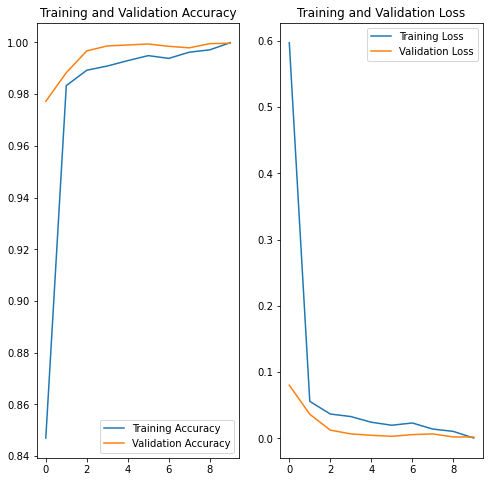

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

model.evaluate(test_ds)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_ds)
pred = np.argmax(pred, axis=1)

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [ ]:
# Map the label

labels = (y_test)
pred_labels = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')


In [ ]:

from sklearn.metrics import accuracy_score
y_test=[]
for image, label in test_ds1.take(22688):
  # print("Image shape: ", image.numpy().shape)
  y_test.append(label.numpy())

accuracy_score(y_test,pred)


You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.